# Memory Information and GPU Information



In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.69GB
Available: 11.85GB
Used: 597.97MB
Percentage: 6.6%


In [ ]:
! nvidia-smi

Thu May 27 17:33:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import utils

# Data

In [ ]:
train_data_ = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor()]))

In [ ]:
torch.manual_seed(1)
batch_size = 64

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation(12),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                           shuffle=True, **kwargs)

test_data = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=True, **kwargs)

In [ ]:
utils.data_stats(train_data_)

Train Statistics
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


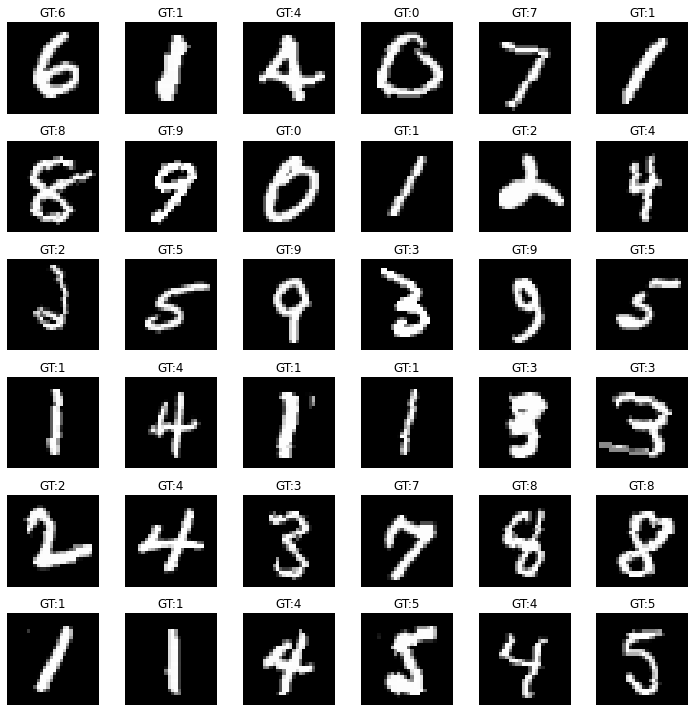

In [ ]:
class_list = [0,1,2,3,4,5,6,7,8,9]
utils.plot_data_grid(train_loader, mean= (0.1307,), std= (0.3081,), class_list=class_list, ncol=6,nrow=6)

# Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1) # 28x28x3 -> 28x28x8
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1) # 28x28x8 -> 28x28x8
        self.bn2 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(2, 2) # 28x28x8 -> 14x14x8
        
        self.conv3 = nn.Conv2d(8, 8, 3) # 14x14x12 -> 12x12x16
        self.bn3 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 8, 3) # 12x12x8 -> 10x10x12
        self.bn4 = nn.BatchNorm2d(8)
        self.conv5 = nn.Conv2d(8, 16, 3) # 10x10x12 -> 8x8x12
        self.bn5 = nn.BatchNorm2d(16)
        self.conv6 = nn.Conv2d(16, 16, 3) # 8x8x12 -> 6x6x16
        
        self.gap = nn.AvgPool2d(6) # 3x3x32 -> 1x1x32
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.pool1(x)

        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.gap(self.conv6(x))
        x = x.view(-1,16)
        x = self.fc2(F.relu(self.fc1(x)))        
        
        
        return F.log_softmax(x, dim=1)

In [ ]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3            [-1, 8, 28, 28]             584
       BatchNorm2d-4            [-1, 8, 28, 28]              16
         MaxPool2d-5            [-1, 8, 14, 14]               0
            Conv2d-6            [-1, 8, 12, 12]             584
       BatchNorm2d-7            [-1, 8, 12, 12]              16
            Conv2d-8            [-1, 8, 10, 10]             584
       BatchNorm2d-9            [-1, 8, 10, 10]              16
           Conv2d-10             [-1, 16, 8, 8]           1,168
      BatchNorm2d-11             [-1, 16, 8, 8]              32
           Conv2d-12             [-1, 16, 6, 6]           2,320
        AvgPool2d-13             [-1, 16, 1, 1]               0
           Linear-14                   

# Train and Test

In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

    train_loss /= len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)

    return train_loss, accuracy

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, accuracy

# Training

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.2, patience=4, 
                            threshold=0.3, threshold_mode='abs', verbose=True)

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train(model, device, train_loader, optimizer)
    test_loss, test_acc = test(model, device, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    scheduler.step(test_acc)
    
    print('\nTRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.3965, Train Accuracy: 86.89%
TEST set: Average loss: 0.0601, Test Accuracy: 98.14%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0886, Train Accuracy: 97.34%
TEST set: Average loss: 0.0572, Test Accuracy: 98.15%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0700, Train Accuracy: 97.83%
TEST set: Average loss: 0.0454, Test Accuracy: 98.55%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0594, Train Accuracy: 98.15%
TEST set: Average loss: 0.0415, Test Accuracy: 98.73%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0553, Train Accuracy: 98.26%
TEST set: Average loss: 0.0341, Test Accuracy: 98.92%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0480, Train Accuracy: 98.52%
TEST set: Average loss: 0.0295, Test Accuracy: 99.01%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0455, Train Accuracy: 98.54%
TEST set: Average loss: 0.0415, Test Accuracy: 98.72%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0424, Train Accuracy: 98.66%
TEST set: Average loss: 0.0260, Test Accuracy: 99.19%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0419, Train Accuracy: 98.70%
TEST set: Average loss: 0.0365, Test Accuracy: 98.85%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch    10: reducing learning rate of group 0 to 2.0000e-03.

TRAIN set: Average loss: 0.0390, Train Accuracy: 98.75%
TEST set: Average loss: 0.0270, Test Accuracy: 99.11%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0315, Train Accuracy: 98.98%
TEST set: Average loss: 0.0204, Test Accuracy: 99.40%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0294, Train Accuracy: 99.06%
TEST set: Average loss: 0.0199, Test Accuracy: 99.39%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0280, Train Accuracy: 99.13%
TEST set: Average loss: 0.0204, Test Accuracy: 99.37%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0270, Train Accuracy: 99.15%
TEST set: Average loss: 0.0196, Test Accuracy: 99.40%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 15


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0274, Train Accuracy: 99.08%
TEST set: Average loss: 0.0197, Test Accuracy: 99.42%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 16


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch    16: reducing learning rate of group 0 to 4.0000e-04.

TRAIN set: Average loss: 0.0267, Train Accuracy: 99.15%
TEST set: Average loss: 0.0191, Test Accuracy: 99.40%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 17


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0269, Train Accuracy: 99.13%
TEST set: Average loss: 0.0192, Test Accuracy: 99.37%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 18


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0256, Train Accuracy: 99.20%
TEST set: Average loss: 0.0187, Test Accuracy: 99.44%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 19


loss=0.06912141293287277 batch_id=937: 100%|██████████| 938/938 [00:20<00:00, 44.90it/s]



TRAIN set: Average loss: 0.0249, Train Accuracy: 99.22%
TEST set: Average loss: 0.0190, Test Accuracy: 99.42%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [ ]:
print('Train Accuracy:', max(train_acc_list))
print('Test Accuracy:', max(test_acc_list))

Train Accuracy: 99.225
Test Accuracy: 99.44


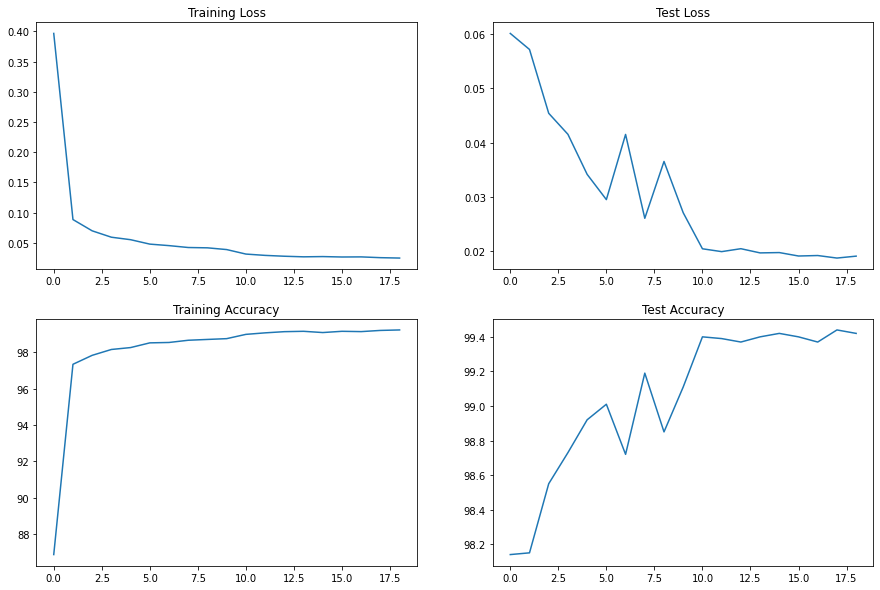

In [ ]:
utils.plot_loss_acc(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

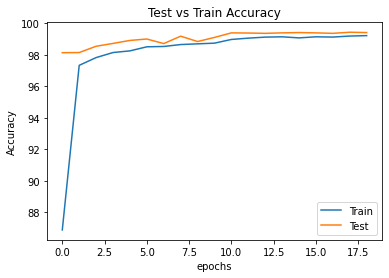

In [ ]:
utils.plot_combined(train_acc_list, test_acc_list)

In [ ]:
images, labels = next(iter(test_loader))
output = model(images.to(device))
predicted = output.argmax(dim=1, keepdim=True).squeeze()

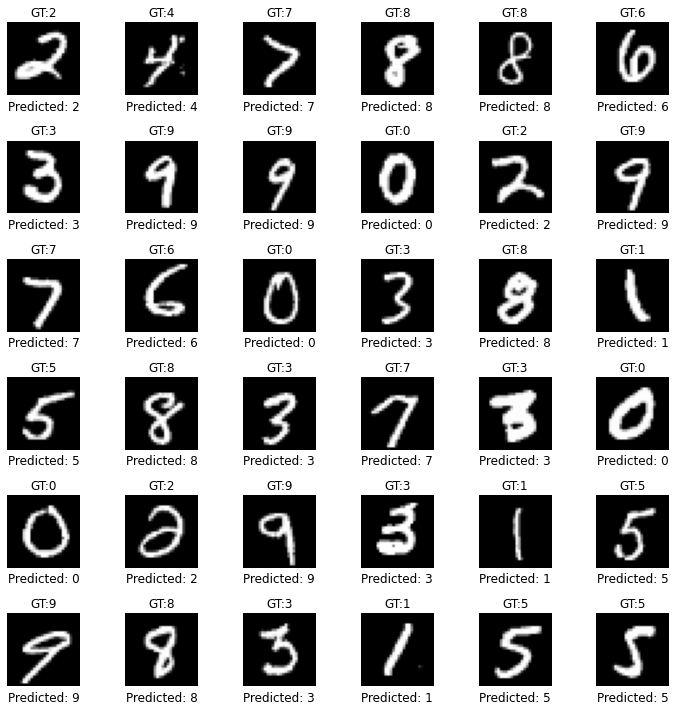

In [ ]:
class_list = [0,1,2,3,4,5,6,7,8,9]
utils.plot_results(images, predicted, labels, mean=(0.1307,), std= (0.3081,), class_list=class_list, ncol=6,nrow=6)